# Temperature Anomaly Detection

The main goal behind this project is to detect the anomailes in the dataset and then train the model so that it could predict the anomalies before hand and thus we could help the covid suspected patients to get tested and take all the major steps needed.

## Algorithm  Implemented

- Cluster Based Anomaly Detection
- Repartition of data into categories then Gaussian/Elliptic Enveloppe on each categories separately
- Markov Chain
- One Class SVM
- RNN (Comparison between prediction and reality)

In [66]:
# libraries
#%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# 1. Data

## 1.1 Extract Data

- Data set extracted from kaggle

In [67]:
master_url_root = "C:\\archive\\"
file_path="realKnownCause\\ambient_temperature_system_failure.csv"
path=master_url_root+file_path
training_df=pd.read_csv(path)

In [68]:
print(training_df.head(10))

             timestamp      value
0  2013-07-04 00:00:00  69.880835
1  2013-07-04 01:00:00  71.220227
2  2013-07-04 02:00:00  70.877805
3  2013-07-04 03:00:00  68.959400
4  2013-07-04 04:00:00  69.283551
5  2013-07-04 05:00:00  70.060966
6  2013-07-04 06:00:00  69.279765
7  2013-07-04 07:00:00  69.369608
8  2013-07-04 08:00:00  69.166714
9  2013-07-04 09:00:00  68.986083


## 1.2 Understand Data

In [69]:
print(training_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None


In [70]:
# check the timestamp format and frequence 
print(training_df['timestamp'].head(10))

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
5    2013-07-04 05:00:00
6    2013-07-04 06:00:00
7    2013-07-04 07:00:00
8    2013-07-04 08:00:00
9    2013-07-04 09:00:00
Name: timestamp, dtype: object


In [71]:
# check the temperature mean
print(training_df['value'].mean())

71.2424327082882


<AxesSubplot:xlabel='timestamp'>

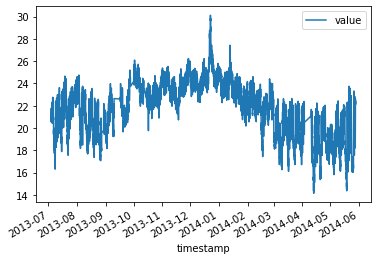

In [72]:
# change the type of timestamp column for plotting
training_df['timestamp'] = pd.to_datetime(training_df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
training_df['value'] = (training_df['value'] - 32) * 5/9
# plot the data
training_df.plot(x='timestamp', y='value')

## 1.3 Feature Engineering

Extracting some useful features.

In [73]:
# the hours and if it's night or day (7:00-22:00)
training_df['hours'] = training_df['timestamp'].dt.hour
training_df['daylight'] = ((training_df['hours'] >= 7) & (training_df['hours'] <= 22)).astype(int)

In [74]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
training_df['DayOfTheWeek'] = training_df['timestamp'].dt.dayofweek
training_df['WeekDay'] = (training_df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [75]:
# time with int to plot easily
training_df['time_epoch'] = (training_df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

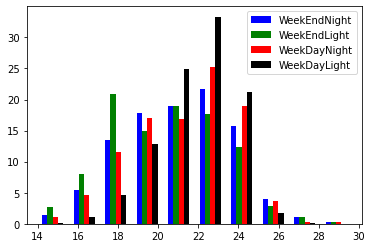

In [76]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
training_df['categories'] = training_df['WeekDay']*2 + training_df['daylight']

a = training_df.loc[training_df['categories'] == 0, 'value']
b = training_df.loc[training_df['categories'] == 1, 'value']
c = training_df.loc[training_df['categories'] == 2, 'value']
d = training_df.loc[training_df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

We can see that the temperature is more stable during the daylight of the business day.

# 2. Models

## 2.1 Cluster Only

**Use for collective anomalies (unordered)**

We group together the usual combination of features. The points that are far from the cluster are the points with usual combination of features. We consider those points as anomalies

In [77]:
# Take useful feature and standardize them
data = training_df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [78]:
training_df

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories
0,2013-07-04 00:00:00,21.044908,0,0,3,1,13728960,2
1,2013-07-04 01:00:00,21.789015,1,0,3,1,13728996,2
2,2013-07-04 02:00:00,21.598781,2,0,3,1,13729032,2
3,2013-07-04 03:00:00,20.533000,3,0,3,1,13729068,2
4,2013-07-04 04:00:00,20.713084,4,0,3,1,13729104,2
...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11,1,2,1,14012748,3
7263,2014-05-28 12:00:00,22.318309,12,1,2,1,14012784,3
7264,2014-05-28 13:00:00,22.248092,13,1,2,1,14012820,3
7265,2014-05-28 14:00:00,22.125126,14,1,2,1,14012856,3


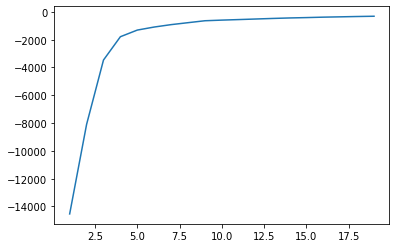

In [79]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [80]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
training_df['cluster'] = kmeans[14].predict(data)
training_df['principal_feature1'] = data[0]
training_df['principal_feature2'] = data[1]
training_df['cluster'].value_counts()

8     607
11    599
4     596
2     576
12    571
10    565
13    532
6     496
0     484
5     466
1     398
14    354
3     347
7     339
9     337
Name: cluster, dtype: int64

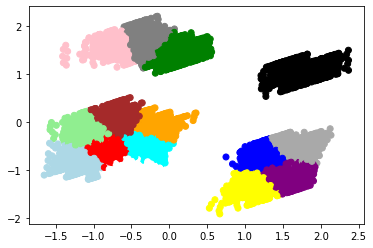

In [81]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(training_df['principal_feature1'], training_df['principal_feature2'], c=training_df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [82]:
def getDistanceByPoint(data, model):
    normal=list()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        normal.append(np.linalg.norm(Xa-Xb))
    distance=pd.Series(normal)
    return distance
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
training_df['anomaly21'] = (distance >= threshold).astype(int)


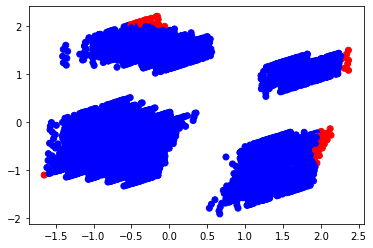

In [83]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(training_df['principal_feature1'], training_df['principal_feature2'], c=training_df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

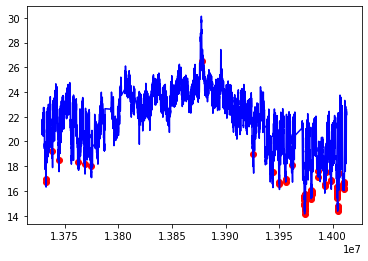

In [84]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = training_df.loc[training_df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(training_df['time_epoch'], training_df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

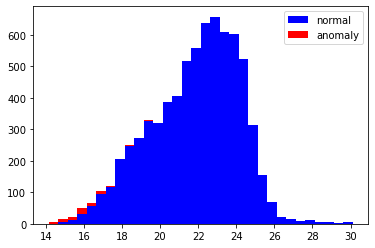

In [85]:
# visualisation of anomaly with temperature repartition (viz 2)
a = training_df.loc[training_df['anomaly21'] == 0, 'value']
b = training_df.loc[training_df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Cluster Method detects the low temperature around the end of record as unusually low. It does'nt detect the highest temperature pic

## 2.2 Categories + Gaussian

**Use for contextual data and collective anomalies (unordered)**
We will separate data by (what we think of) important categories. Or we can separate data based on different cluster (method 2.3). Then we find outliers (gaussian repartition, unimodal) by categories independently.

In [86]:
# creation of 4 differents data set based on categories defined before
df_class0 = training_df.loc[training_df['categories'] == 0, 'value']
df_class1 = training_df.loc[training_df['categories'] == 1, 'value']
df_class2 = training_df.loc[training_df['categories'] == 2, 'value']
df_class3 = training_df.loc[training_df['categories'] == 3, 'value']

<AxesSubplot:>

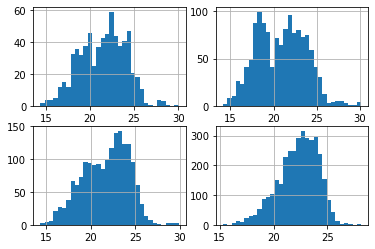

In [87]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

In [88]:
# apply ellipticEnvelope(gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

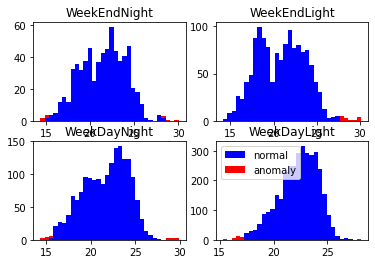

In [89]:
# plot the temperature repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [90]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
training_df['anomaly22'] = df_class['anomaly']
training_df['anomaly22'] = np.array(training_df['anomaly22'] == -1).astype(int) 

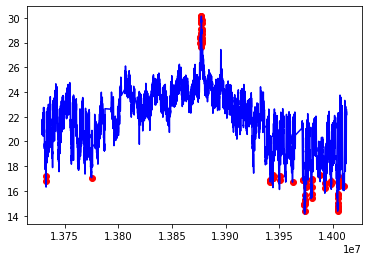

In [91]:
fig, ax = plt.subplots()

a = training_df.loc[training_df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(training_df['time_epoch'], training_df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

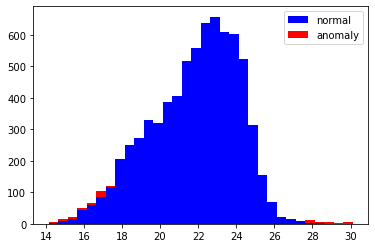

In [92]:
# visualisation of anomaly with temperature repartition (viz 2)
a = training_df.loc[training_df['anomaly22'] == 0, 'value']
b = training_df.loc[training_df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Good detections of extreme values and context separation add some precision to the detection

## 2.3 Markov Chains 

**Use for sequential anamolies (ordered)**
We need discretize the data points in define states for markov chain. We will just take 'value' to define state for this example and define 5 levels of value (very low, low, average, high, very high)/(VL, L, A, H, VH). Markov chain will calculate the probability of sequence like (VL, L, L, A, A, L, A). If the probability is very weak we consider the sequence as an anomaly.

In [93]:
# definition of the different state
x1 = (training_df['value'] <=18).astype(int)
x2= ((training_df['value'] > 18) & (training_df['value']<=21)).astype(int)
x3 = ((training_df['value'] > 21) & (training_df['value']<=24)).astype(int)
x4 = ((training_df['value'] > 24) & (training_df['value']<=27)).astype(int)
x5 = (training_df['value'] >27).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5

In [94]:
# train markov model to get transition matrix
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1)
	return model.transition_matrix
def anomalyElement(sequence, threshold, transition_matrix):
    if (sucessScore(sequence, transition_matrix) > threshold):
        return 0
    else:
        return 1
# return the success probability of the whole sequence
def sucessScore(sequence, transition_matrix):
    proba = 0 
    for i in range(1,len(sequence)):
        if(i == 1):
            proba = successProbabilityMetric(sequence[i-1], sequence[i], transition_matrix)
        else:
            proba = proba*successProbabilityMetric(sequence[i-1], sequence[i], transition_matrix)
    return proba
# return the success probability of the state change 
def successProbabilityMetric(state1, state2, transition_matrix):
    proba = 0
    for k in range(0,len(transition_matrix)):
        if (k != (state2-1)):
            proba += transition_matrix[state1-1][k]
    return 1-proba

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly
# getting the anomaly labels for our dataset (evaluating sequence of 5 values and anomaly = less than 20% probable)
df_anomaly = markovAnomaly(df_mm, 5, 0.20)
df_anomaly = pd.Series(df_anomaly)
print(df_anomaly.value_counts())

0    7147
1     120
dtype: int64


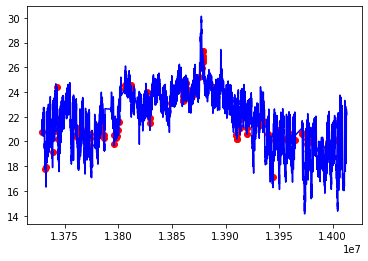

In [95]:
# add the data to the main 
training_df['anomaly24'] = df_anomaly

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = training_df.loc[training_df['anomaly24'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(training_df['time_epoch'], training_df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

No handles with labels found to put in legend.


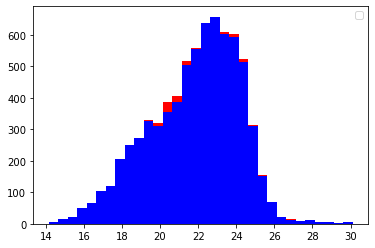

In [30]:
# visualisation of anomaly with temperature repartition (viz 2)
a = training_df.loc[training_df['anomaly24'] == 0, 'value']
b = training_df.loc[training_df['anomaly24'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

Detect unusual sequence but not extreme value. More difficult to evaluate the relevance on this example. The sequence size (5) should be match with some interesting cycle.

## 2.5 Isolation Forest

**Use for collective anomalies (unordered)** Simple, works well with different data repartition and efficient with high dimention data.

In [31]:
# Take useful feature and standardize them 
data = training_df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
training_df['anomaly25'] = pd.Series(model.predict(data))
training_df['anomaly25'] = training_df['anomaly25'].map( {1: 0, -1: 1} )
print(training_df['anomaly25'].value_counts())

0    7194
1      73
Name: anomaly25, dtype: int64


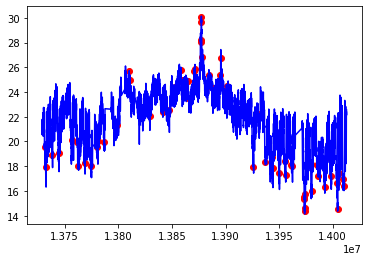

In [32]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = training_df.loc[training_df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(training_df['time_epoch'], training_df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

No handles with labels found to put in legend.


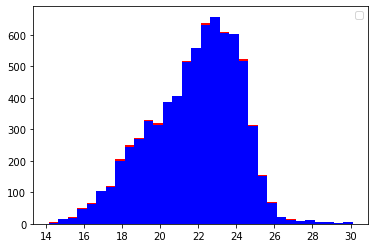

In [33]:

# visualisation of anomaly with temperature repartition (viz 2)
a = training_df.loc[training_df['anomaly25'] == 0, 'value']
b = training_df.loc[training_df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

## 2.6 One class SVM
**Use for collective anomalies (unordered).** Good for novelty detection (no anomalies in the train set). This algorithm performs well for multimodal data.

In [34]:
# Take useful feature and standardize them 
data = training_df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
training_df['anomaly26'] = pd.Series(model.predict(data))
training_df['anomaly26'] = training_df['anomaly26'].map( {1: 0, -1: 1} )
print(training_df['anomaly26'].value_counts())

0    7198
1      69
Name: anomaly26, dtype: int64


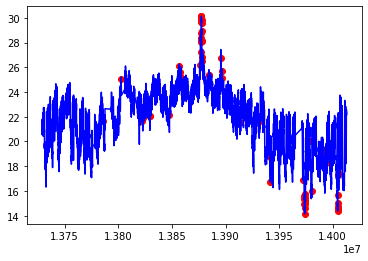

In [35]:

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = training_df.loc[training_df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(training_df['time_epoch'], training_df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

No handles with labels found to put in legend.


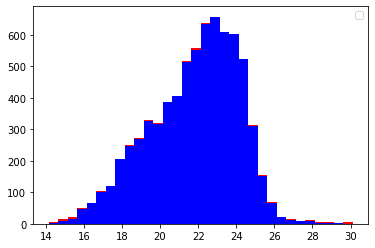

In [36]:
# visualisation of anomaly with temperature repartition (viz 2)
a = training_df.loc[training_df['anomaly26'] == 0, 'value']
b = training_df.loc[training_df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

Give result similar to isolation forest but find some anomalies in average values. Difficult to know if it's relevant.

## 2.7 RNN

**Use for sequential anomalies (ordered)**

RNN learn to recognize sequence in the data and then make prediction based on the previous sequence. We consider an anomaly when the next data points are distant from RNN prediction. Aggregation, size of sequence and size of prediction for anomaly are important parameters to have relevant detection.
Here we make learn from 50 previous values, and we predict just the 1 next value.

In [37]:
#select and standardize data
data_n = training_df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut  ][0].values

# test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values

In [38]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [39]:
# specific libraries for RNN
# keras is a high layer build on Tensorflow layer to stay in high level/easy implementation
from keras.layers import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json

In [42]:
model = Sequential()

model.add(LSTM(50,input_dim=x_train.shape[-1], return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.003999948501586914


In [57]:
model.fit(
    x_train,
    y_train,
    batch_size=3028,
    epochs=50,
    validation_split=0.1)

Epoch 1/50
2/2 [==============================] - 4s 2s/step - loss: 0.2751 - val_loss: 0.6690
Epoch 2/50
2/2 [==============================] - 4s 2s/step - loss: 0.1901 - val_loss: 0.3872
Epoch 3/50
2/2 [==============================] - 4s 2s/step - loss: 0.1285 - val_loss: 0.3059
Epoch 4/50
2/2 [==============================] - 4s 2s/step - loss: 0.1203 - val_loss: 0.2596
Epoch 5/50
2/2 [==============================] - 4s 2s/step - loss: 0.1060 - val_loss: 0.2541
Epoch 6/50
2/2 [==============================] - 4s 2s/step - loss: 0.1199 - val_loss: 0.2203
Epoch 7/50
2/2 [==============================] - 4s 2s/step - loss: 0.0911 - val_loss: 0.1866
Epoch 8/50
2/2 [==============================] - 4s 2s/step - loss: 0.0882 - val_loss: 0.1705
Epoch 9/50
2/2 [==============================] - 4s 2s/step - loss: 0.0922 - val_loss: 0.1623
Epoch 10/50
2/2 [==============================] - 4s 2s/step - loss: 0.0950 - val_loss: 0.1571
Epoch 11/50
2/2 [==============================] 

In [58]:
# serialize model to JSON
model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model2.h5")
print("Saved model to disk")

Saved model to disk


In [59]:
json_file = open('model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model2.h5")
print("Loaded model from disk")

Loaded model from disk


In [60]:
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

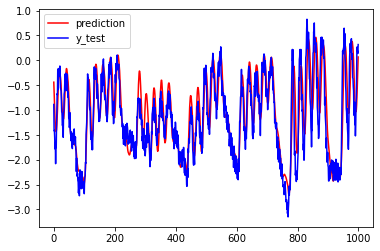

In [61]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [62]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
# # add the data to the main
training_df['anomaly27'] = complement.append(test, ignore_index='True')
print(training_df['anomaly27'].value_counts())

0    7257
1      10
Name: anomaly27, dtype: int64


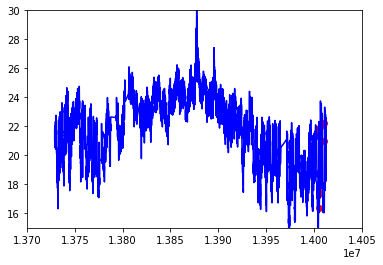

In [64]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = training_df.loc[training_df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(training_df['time_epoch'], training_df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.show()

No handles with labels found to put in legend.


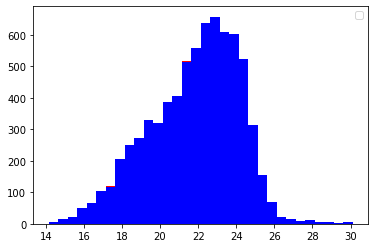

In [65]:
# visualisation of anomaly with temperature repartition (viz 2)
a = training_df.loc[training_df['anomaly27'] == 0, 'value']
b = training_df.loc[training_df['anomaly27'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

# 3 Result Comparison

# 4 Conclusion